<h2 align="center">BERT: Classify spam vs no spam emails</h2>

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

<h4>Import the dataset (Dataset is taken from kaggle)</h4>

In [2]:
import pandas as pd

df = pd.read_csv("spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

#### Exploring Data

In [4]:
df['Category'].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [5]:
747/4825

0.15481865284974095

**15% spam emails, 85% ham emails: This indicates class imbalance**

#### Over Sampling

In [12]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [13]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [14]:
df_spam_oversampled = df_spam.sample(n=len(df_ham), replace=True)
df_spam_oversampled.shape

(4825, 2)

In [51]:
df_spam_oversampled.head(10)

,Category,Message
1767,spam,SMS AUCTION You have won a Nokia 7250i. This i...
2558,spam,This message is brought to you by GMW Ltd. and...
3299,spam,This message is free. Welcome to the new & imp...
2413,spam,I don't know u and u don't know me. Send CHAT ...
42,spam,07732584351 - Rodger Burns - MSG = We tried to...
2980,spam,"Xmas Offer! Latest Motorola, SonyEricsson & No..."
2705,spam,FreeMsg: Fancy a flirt? Reply DATE now & join ...
1915,spam,New TEXTBUDDY Chat 2 horny guys in ur area 4 j...
2818,spam,Gr8 Poly tones 4 ALL mobs direct 2u rply with ...
850,spam,Today's Offer! Claim ur £150 worth of discount...


In [15]:
df_balanced = pd.concat([df_spam_oversampled, df_ham])
df_balanced.shape

(9650, 2)

In [16]:
df_balanced['Category'].value_counts()

Category
spam    4825
ham     4825
Name: count, dtype: int64

In [18]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
3105,ham,That's y i said it's bad dat all e gals know u...,0
2089,spam,Well done ENGLAND! Get the official poly ringt...,1
1947,ham,Hey we can go jazz power yoga hip hop kb and y...,0
833,spam,"Dear Voucher Holder, To claim this weeks offer...",1
1115,ham,No no:)this is kallis home ground.amla home to...,0


<h4>Split it into training and test data set</h4>

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

<h4>Now lets import BERT model and get embeding vectors for few sample statements</h4>

In [20]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [21]:
text_test = ["500$ discount. hurry up"]
text_preprocessed = bert_preprocess(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (2, 128)
Word Ids   : [  101  3156  1002 19575  1012  9241  2039   102     0     0     0     0]
Input Mask : [1 1 1 1 1 1 1 1 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


### Get embeding vectors for few sample words. Compare them using cosine similarity


In [40]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435172 , -0.51327366, -0.88845867, ..., -0.7474904 ,
        -0.75314796,  0.919645  ],
       [-0.8720835 , -0.50544006, -0.94446737, ..., -0.858476  ,
        -0.71745366,  0.88082975]], dtype=float32)>

In [41]:
embeding = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [42]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([embeding[0]],[embeding[1]])

array([[0.9911088]], dtype=float32)

Values near to 1 means they are similar. 0 means they are very different. Above you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits



In [53]:
cosine_similarity([embeding[0]],[embeding[3]])


array([[0.84703857]], dtype=float32)

Comparing banana with jeff bezos you still get 0.84 but it is not as close as 0.99 that we got with grapes

In [54]:
cosine_similarity([embeding[3]],[embeding[4]])

array([[0.98720354]], dtype=float32)

Jeff bezos and Elon musk are more similar then Jeff bezos and banana as indicated above

<h4>Build Model</h4>

There are two types of models you can build in tensorflow. 

(1) Sequential
(2) Functional

So far we have built sequential model. But below we will build functional model. More information on these two is here: https://becominghuman.ai/sequential-vs-functional-model-in-keras-20684f766057

In [22]:
def build_classifier_model():
    
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(bert_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(bert_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(net)
    return tf.keras.Model(text_input, net)

In [23]:
clf_model = build_classifier_model()

ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.


https://stackoverflow.com/questions/47605558/importerror-failed-to-import-pydot-you-must-install-pydot-and-graphviz-for-py

In [24]:
clf_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_type_ids': (None,                                           
                              128),                                                               
                              'input_word_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [25]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

clf_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

<h4>Train the model</h4>

In [26]:
clf_model.fit(X_train, y_train, epochs=10)

Epoch 1/10
227/227 [==============================] - 1543s 7s/step - loss: 0.4657 - accuracy: 0.8077 - precision: 0.7941 - recall: 0.8306
Epoch 2/10
227/227 [==============================] - 1677s 7s/step - loss: 0.2965 - accuracy: 0.9023 - precision: 0.8889 - recall: 0.9196
Epoch 3/10
227/227 [==============================] - 1720s 8s/step - loss: 0.2426 - accuracy: 0.9199 - precision: 0.9094 - recall: 0.9326
Epoch 4/10
227/227 [==============================] - 1704s 8s/step - loss: 0.2129 - accuracy: 0.9340 - precision: 0.9297 - recall: 0.9389
Epoch 5/10
227/227 [==============================] - 1657s 7s/step - loss: 0.1880 - accuracy: 0.9438 - precision: 0.9412 - recall: 0.9467
Epoch 6/10
227/227 [==============================] - 1517s 7s/step - loss: 0.1717 - accuracy: 0.9500 - precision: 0.9485 - recall: 0.9516
Epoch 7/10
227/227 [==============================] - 1652s 7s/step - loss: 0.1593 - accuracy: 0.9523 - precision: 0.9519 - recall: 0.9527
Epoch 8/10
227/227 [=======

In [28]:
clf_model.evaluate(X_test, y_test)

76/76 [==============================] - 460s 6s/step - loss: 0.1291 - accuracy: 0.9619 - precision: 0.9581 - recall: 0.9660


[0.12907546758651733,
 0.9618731737136841,
 0.9580936431884766,
 0.9660314917564392]

In [29]:
y_predicted = clf_model.predict(X_test)
y_predicted = y_predicted.flatten()

76/76 [==============================] - 462s 6s/step


In [30]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 0, ..., 1, 1, 1])

In [31]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[1155,   51],
       [  41, 1166]])

Text(50.722222222222214, 0.5, 'Truth')

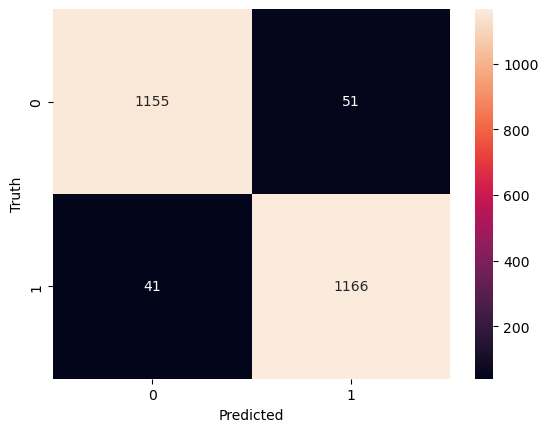

In [32]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [33]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1206
           1       0.96      0.97      0.96      1207

    accuracy                           0.96      2413
   macro avg       0.96      0.96      0.96      2413
weighted avg       0.96      0.96      0.96      2413



In [59]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, y_predicted))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 0.19526088470487749


### Saved Model

In [34]:
dataset_name = 'spam'
saved_model_path = './{}_model_2'.format(dataset_name.replace('/', '_'))

clf_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./spam_model_2/assets


INFO:tensorflow:Assets written to: ./spam_model_2/assets


In [35]:
print(saved_model_path)

./spam_model_2


In [36]:
reloaded_model = tf.keras.models.load_model('./spam_model_2')

### Interface

In [60]:
def print_my_examples(inputs, results):
    for input_text, result in zip(inputs, results):
        formatted_score = "{:.4f}".format(result[0])
        print(f'input: {input_text:<80} : score: {formatted_score}')
    print()

examples = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005',
    'Hey Sam, Are you coming for a cricket game tomorrow?',
    "I told you to submit your work before morning, you dint submitted yet!!"
    
]

predicted_labels = reloaded_model.predict(examples)

print('Results from the saved model:')
print_my_examples(examples, predicted_labels)


1/1 [==============================] - 1s 954ms/step
Results from the saved model:
input: Enter a chance to win $5000, hurry up, offer valid until march 31, 2021          : score: 0.9189
input: You are awarded a SiPix Digital Camera! call 09061221061 from landline           : score: 0.9316
input: it to 80488. Your 500 free text messages are valid until 31 December 2005        : score: 0.8980
input: Hey Sam, Are you coming for a cricket game tomorrow?                             : score: 0.0476
input: I told you to submit your work before morning, you dint submitted yet!!          : score: 0.0785

